In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

import mygrad as mg
import numpy as np

# Training a Universal Function Approximator

The *universal approximation theorem* states:

Let $ \varphi (\cdot )$ be a nonconstant, bounded, and monotonically-increasing continuous function. Let $ I_m $ denote any compact subset of $ \mathbb {R} ^{m} $. The space of continuous functions $I_m  \mapsto \mathbb {R}$ is denoted by $C(I_{m})$. 

Then, given any $\varepsilon >0$ and any function $f\in C(I_{m})$, there exist an integer $N$, real constants $v_{i},b_{i}\in \mathbb {R}$ and real vectors $w_{i}\in \mathbb {R} ^{m}$, where $i=1,\cdots ,N$, such that we may define:

\begin{equation}
F(x) = \sum_{i=1}^{N} v_{i}\varphi(x \cdot w_{i} + b_{i})
\end{equation}

as an approximate realization of the function $f$ where $f$ is independent of $\varphi$ ; that is,

\begin{equation}
| F( x ) - f ( x ) | < \varepsilon
\end{equation}

for all $ x\in I_{m}$. See that $x \cdot w_{i}$ is the dot product between $x$ and $w_{i}$, which are $m$-dimensional vectors.

This theorem was first proved in 1989, using the *sigmoid function* as $\varphi$:

\begin{equation}
\varphi(x) = \frac{1}{1 + e^{-x}}
\end{equation}


## Our problem
Here, we will try to find values for the parameters $N,v_{i},b_{i},w_{i}$  (where $i=1,\cdots ,N$) such that $F(x)$ approximates 

\begin{equation}
f(x) = \cos(x)\\
x \in [-2\pi, 2\pi]
\end{equation}

Using the sigmoid function as $\varphi$.

Because $\cos(x)$ maps $[-2\pi, 2\pi]  \mapsto [-1, 1]$, $x$ and $w_{i}$ are scalars. In the future we will be working with high dimensional data, so we will want to treat $x$ and $w_{i}$ as 1-dimensional vectors (i.e. length-1 tensors) here; this will make it trivial to adapt our code to higher dimensional data later on.

We will search for optimal values of $v_{i},b_{i},w_{i}$ via *gradient descent*, using the obvious loss function:

\begin{equation}
L(x) = | F( x ) - \cos ( x ) |
\end{equation}

The *number* of parameters to use, $N$, is a hyper parameter, which we must find through trial and error.

### Plotting our "activation function"

Import the `sigmoid` from `mygrad.nnet.activations`. Plot this function on the domain $[-10, 10]$. 

Is this a "nonconstant, bounded, and monotonically-increasing continuous function", as demanded for $\varphi$ by the universal approximation theorem?

What does the sigmoid function do to "extreme" values of $x$? What mechanism might this serve? Discuss with neighbors.

<IPython.core.display.Javascript object>


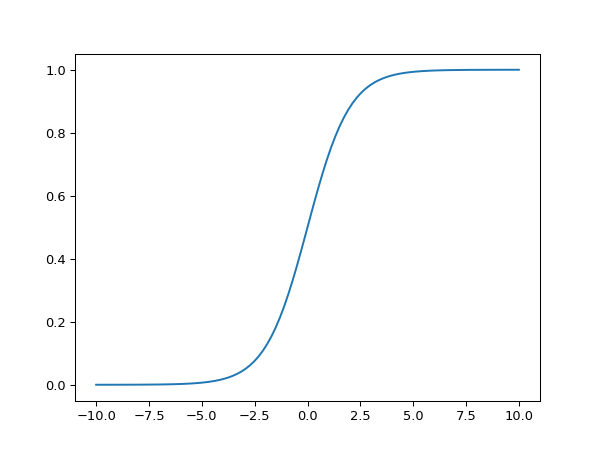

In [12]:
# STUDENT CODE
from mygrad.nnet.activations import sigmoid
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
y = sigmoid(mg.linspace(-10,10,100))
fig, ax = plt.subplots()
ax = plt.plot(np.linspace(-10,10,100),y)

### Choosing N and initializing our parameters

Write a function `create_parameters`, which takes an input integer `N`, and initializes the following parameters:

- `w`: a shape-(1, N) `Tensor` with data drawn randomly from `np.random.randn`
- `b`: a shape-(N,) `Tensor` with data drawn randomly from `np.random.randn`
- `v`: a shape-(N, 1) `Tensor` with data drawn randomly from `np.random.randn`

and returns the tuple `(w, b, v)`.

`np.random.randn` draws numbers from a Gaussian distribution (bell curve) that is centered at 0, and has a standard deviation of 1.

In [13]:
# STUDENT CODE
def create_parameters(n):
    """ Parameters
        ----------
        n : int 
            The number of parameters to use in our function approximator for
            w, b, and v."""
    
    w = mg.Tensor(np.random.randn(n)).reshape(1,n)
    b = mg.Tensor(np.random.randn(n))
    v = mg.Tensor(np.random.randn(n)).reshape(n,1)
    return (w,b,v)
    
    pass


### Write a gradient-descent function
Write a gradient descent function that accepts a tuple of tensors and a *learning rate* ($\delta$). 

For each tensor, update its *underlying numpy array* according to gradient descent. Skip the tensor if its gradient is `None`. Because you are modifying the data of these tensors in-place, this function need not return anything. Write a good docstring for the function.

In [14]:
# STUDENT CODE
def gradient_descent(tensors,rate):
    for t in tensors:
        if t.grad is not None:
            t.data -= t.grad * rate

### Writing our approximating function (a.k.a our "model")

We will now write a `forward_pass` function for our "model", which is the approximating function $F(x)$. Thus this function should accept in the value $x$ (i.e. the "data"), along with the parameters of our model: `w`, `b`, and `v`.

It is computationally inefficient to train our model by passing it one number $x$ at a time. Rather, we will want to pass in a *batch* of $M$ numbers $x_{j}$ ($j=1,\cdots ,M$), and evaluate our model for each of these values independently: $F(x_{j})$  

We will do this using vectorization and not for-loops, of course. Thus `x` will be a shape-$(M, 1)$ numpy-array instead of a single number.

Recall that

\begin{equation}
x_j \cdot w_{i}
\end{equation}

can be evaluated all combinations of $j=1,\cdots ,M$ and $i=1,\cdots ,N$ via simple matrix multiplication between the shape-$(M, 1)$ `x` and the shape-$(1, N)$ `w`, producing a shape-$(M, N)$ output. And thus the following expression:

\begin{equation}
\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for all $j$ and $i$ via broadcasting:

```python
sigmoid(mg.matmul(x, w) + b) # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
```

Multiplying each such term by $v_{i}$ and summing over $i$ is thus just another matrix multiplication:

\begin{equation}
F(x_{j}) = \sum_{i=1}^{N} v_{i}\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for each `j` via:
```python
out1 = sigmoid(mg.matmul(x, w) + b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
model_out = mg.matmul(out1, v)       # matmul[(M, N) w/ (N, 1)] --> (M, 1)
```

Write a `forward_pass` function that accepts a batch of shape-(M, 1), the model's parameters, and produces (M, 1) predictions for our approximating function. Include a good docstring.

In [15]:
# STUDENT CODE
def forward_pass(x,w,b,v):
    return mg.matmul(sigmoid(mg.matmul(x,w)+b),v)

### Writing a loss function

For the problem at hand, it is quite natural to choose our loss function to be:

\begin{equation}
L(x) = | F( x ) - \cos ( x ) |
\end{equation}

which is called the "L1-loss". Our loss grows linearly with the disagreement between our approximating function and the "true" function.

Note, however, that we want to make predictions size-$M$ batches. Thus we will have:

\begin{equation}
L(x_{j}) = | F( x_{j} ) - \cos ( x_{j} ) |
\end{equation}

for each $j=1,\cdots ,M$. 

That being said, we want to ultimately have a *single scalar loss*, thus we will compute our total loss as the *average* over $L(x_{j})$:

\begin{equation}
L = \frac{1}{M}\sum_{j=1}^{M} | F( x_{j} ) - \cos ( x_{j} ) |
\end{equation}

Write the function `l1_loss`, which accepts the shape-(M,1) batch of *predictions* from our model along with the shape-(M, 1) *true* values (which we are hoping to approximate) and return $L$.

Make sure that you are using functions from mygrad and not numpy, so that we can back-propagate through this loss!

Make a simple test to ensure that your loss is computing the correct values.

In [16]:
# STUDENT CODE
def l1_loss(pred,true):
    M = len(pred)
    L = 1/M * mg.sum(mg.abs(pred-true))
    return L


## Preparing the training data
You will create a numpy-array or *constant-Tensor* that samples $[-2\pi, 2\pi]$ evenly using 1,000 points. Call this `train_data`. This should have the shape (1000, 1). (You will do this lower down in the notebook).

Why is it important that we use numpy-arrays or constant tensors? Why would it be inefficient to perform back-propagation if our training data were non-constant tensors? Discuss with your neighbors.

### Training Our Approximating Function! 

We will use the handy 'liveplot' package to keep track of how our loss is evolving during training. The following code will create a plotter that will keep track of "loss", and will refresh itself every 2 seconds, during training:

```python
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss"], refresh=2)
ax.set_ylim(0, 1)
```
When you compute the loss for the training batch, you can add them to the liveplot:

```python
plotter.set_train_batch({"loss" : loss.item()},
                         batch_size=batch_size)
```

Notice that `set_train_batch` accepts a dictionary of metric-name $\rightarrow$ metric-value.
We will need to make take randomized "batches" of our training data, and use them to train our model. Each time we process all of the batches in our training data, we have completed an "epoch" of training.

Below, we will use batches of size-25. Thus we will need to process $1000/25 = 40$ batches to complete an epoch of training.

Here, we will set up our training data, initialize our model's parameters, set our batch size, and define the function that we are attempting to approximate. We will also create a plot that updates during training

### Define the function you want to train

In [20]:
def true_f(x):
    return np.cos(x)  # change np.cos(x) to a different function


<IPython.core.display.Javascript object>


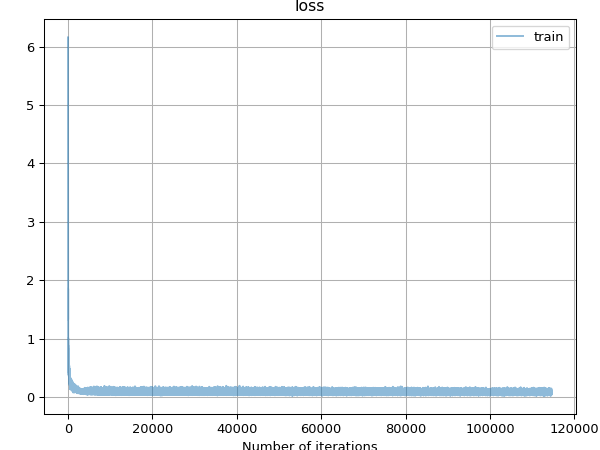

In [21]:
# STUDENT CODE
# Running this code will recreate your model, re-initializing all of its parameters
# Thus you must re-run this cell if you want to train your model from scratch again.
# Create the liveplot figure using the code snippet above
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss"], refresh=2.5)

# Create the shape-(1000,1) training data

# Create your parameters using your function `create_parameters`; 
# start off with N=10 for the number of model parameters
# to use for defining F(x)
train_data = np.linspace(-2 * np.pi,2 * np.pi,1000).reshape(1000,1)
batch_size = 25
w, b, v = create_parameters(70)
# Set `batch_size = 25`: the number of predictions that we will make in each training step



In [22]:
#STUDENT CODE
# running this code will train your model; you can run it consecutively,
# with different learning rates to continue training your model.

# set your "learning rate": the scaling parameter in gradient descent
# try a value of 0.01 to start
lr = 0.01


# We will train for 1000 epochs; you can change this if you'd like
for epoch_cnt in range(3000):
    
    idxs = np.arange(len(train_data))  # -> array([0, 1, ..., 9999])
    # shuffles these indices; we will use this to draw random batches
    # from our training data
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(train_data)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_data[batch_indices]  # random batch of our training data
        
        # compute the predictions for this batch: F(x; w, b, v)
        pred = forward_pass(batch,w,b,v)
        # compute the true (a.k.a desired) values for this batch: f(x) 
        true = true_f(batch)
        # compute the loss associated with our predictions
        loss = l1_loss(pred,true)
        # back-propagate through your computational graph through your loss
        # this will compute: dL/dw, dL/db, dL/dv
        loss.backward()
        # execute your gradient descent function, passing all of your model's
        # parameters (w, b, v), and the learning rate. This will update your
        # model's parameters based on the loss that was computed
        gradient_descent((w,b,v),lr)
        # FOR THE LOVE OF ALL THAT IS GOOD: NULL YOUR GRADIENTS
        loss.null_gradients()
        w_mean = mg.mean(w)
        # this will plot add your loss value to the liveplot. Note that
        # `loss.item()` returns a float - we can't pass the plotter a 0D-Tensor
        plotter.set_train_batch({"loss" : loss.item()},
                               batch_size=batch_size)
        
        
        

To evaluate the quality of your model (i.e. your approximating function $F(x)$), plot $f(x)$ (the desired function) and $F(x)$ on the sample plot. Use `train_data` as your `x` values. 

<IPython.core.display.Javascript object>


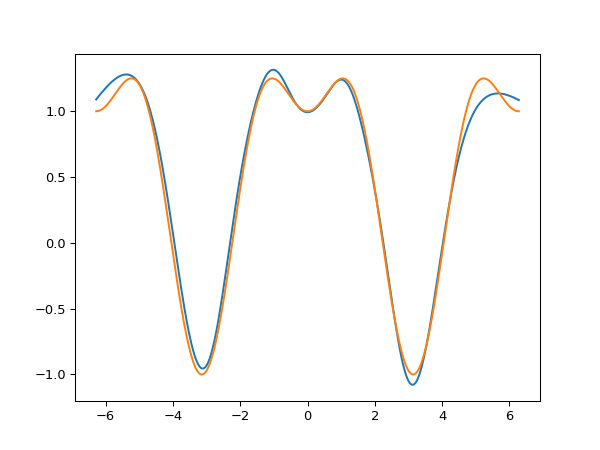

In [18]:
# STUDENT CODE
fig, ax = plt.subplots()
ax.plot(train_data,forward_pass(train_data,w,b,v))
ax.plot(train_data,true_f(train_data))

### Things to Try (be sure to preserve any good code you have before trying these things)
- Once your loss curve (often called the "learning curve") plateaus, try reducing the learning rate and resume training. This will likely lower your loss further.
- Once you have a good model, try plotting $f(x)$ and $F(x)$ *beyond* the domain that you trained it on. For example, try plotting them on $[-4\pi, 4\pi]$. What do you see? Is this reasonable? Discuss with a neighbor.
- Try decreasing the the parameter-number in your model from $N=10$ down to $N=1$. Thus `w` will have the shape (1, 1) instead of (1, 10), etc. Train this model as best you can, and plot $F(x)$. What shape does this take? Can you explain why?
- Using $N=10$, repeat your training but train on the domain $[2\pi, 6\pi]$. Are you able to get your model to train well? Why should shifting the domain have any affect if $f(x)$ is perfectly periodic. Consider what special properties our original domain, $[-2\pi, 2\pi]$ has. Consider, also, how we initialize our model's parameters. Discuss with your neighbor what you suspect might be the issue here. You can use `liveplot` to plot the mean values of `w`, `v`, and `b` as you train. You can also plot the mean values of the gradients that are back-propagating through your model, with some minor modifications to your code. This is very interesting to visualize.
- Fit a different $f(x)$ other than cosine. Do you need more parameters to approximate more complicated functions?
- Try increasing $N$ to $N=1000$. You may need to try adjusting your learning rate during training, lowering it as you go. Does increasing $N$ make things better or worse in this instance?

In [11]:
# plotting F(x) outside of its training domain

# STUDENT CODE

In [12]:
# training the model using N=1

# INTERPRETATION: For N=1, F(x) = v * sigmoid(x*w + b), thus F(x) must
# have the form of a sigmoid function (albeit a shallow one)

# STUDENT CODE

In [ ]:
# visualizing w_grad.mean()

# STUDENT CODE